In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load
df = pd.read_csv("dataset/salesdaily.csv")

In [6]:
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datum         2106 non-null   object 
 1   M01AB         2106 non-null   float64
 2   M01AE         2106 non-null   float64
 3   N02BA         2106 non-null   float64
 4   N02BE         2106 non-null   float64
 5   N05B          2106 non-null   float64
 6   N05C          2106 non-null   float64
 7   R03           2106 non-null   float64
 8   R06           2106 non-null   float64
 9   Year          2106 non-null   int64  
 10  Month         2106 non-null   int64  
 11  Hour          2106 non-null   int64  
 12  Weekday Name  2106 non-null   object 
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


In [9]:
# 1. Convert to datetime
df['datum'] = pd.to_datetime(df['datum'])

# 2. Keep only sales columns
sales_cols = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# 3. Aggregate daily totals (ignore Hour, Year, Month, Weekday Name for now)
df_daily_agg = df.groupby('datum')[sales_cols].sum().reset_index()

# 4. Reshape to long format for Prophet
df_daily_long = df_daily_agg.melt(id_vars=['datum'],
                                  var_name='category',
                                  value_name='units_sold')

print(df_daily_long.head())


       datum category  units_sold
0 2014-01-02    M01AB         0.0
1 2014-01-03    M01AB         8.0
2 2014-01-04    M01AB         2.0
3 2014-01-05    M01AB         4.0
4 2014-01-06    M01AB         5.0


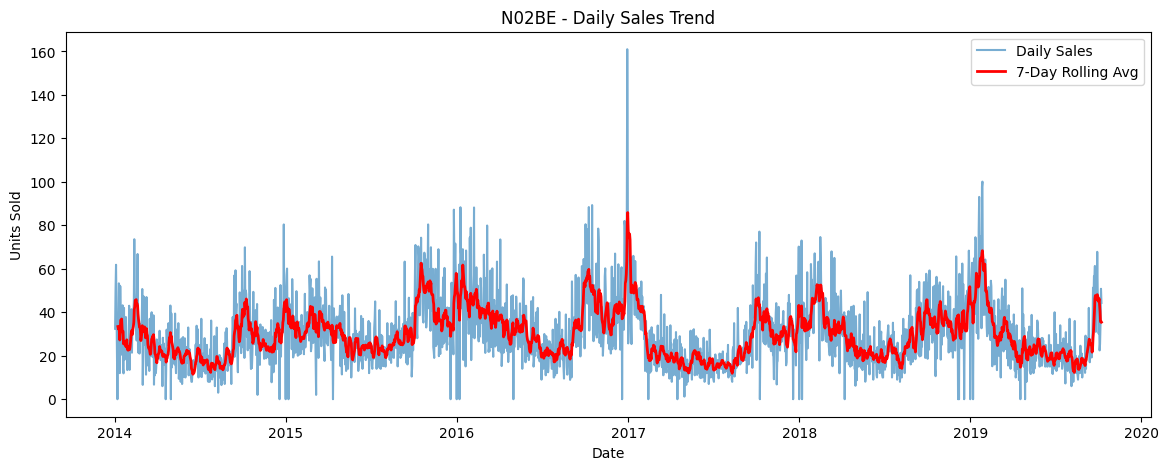

In [10]:

# Pick one category to visualize first (example: N02BE)
df_n02be = df_daily_long[df_daily_long['category'] == 'N02BE']

plt.figure(figsize=(14,5))
plt.plot(df_n02be['datum'], df_n02be['units_sold'], label='Daily Sales', alpha=0.6)
plt.plot(df_n02be['datum'], df_n02be['units_sold'].rolling(7).mean(), 
         label='7-Day Rolling Avg', color='red', linewidth=2)
plt.title("N02BE - Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


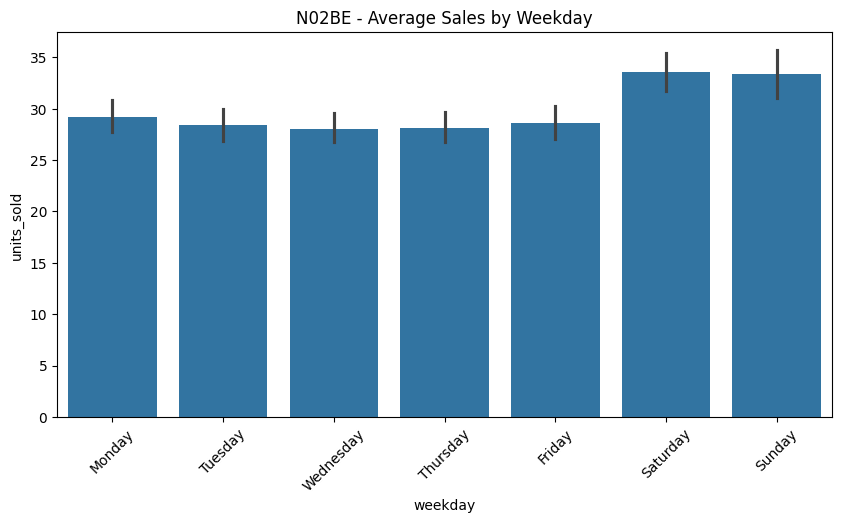

In [11]:
# Extract weekday from date
df_daily_long['weekday'] = df_daily_long['datum'].dt.day_name()

plt.figure(figsize=(10,5))
sns.barplot(data=df_daily_long[df_daily_long['category'] == 'N02BE'],
            x='weekday', y='units_sold',
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("N02BE - Average Sales by Weekday")
plt.xticks(rotation=45)
plt.show()


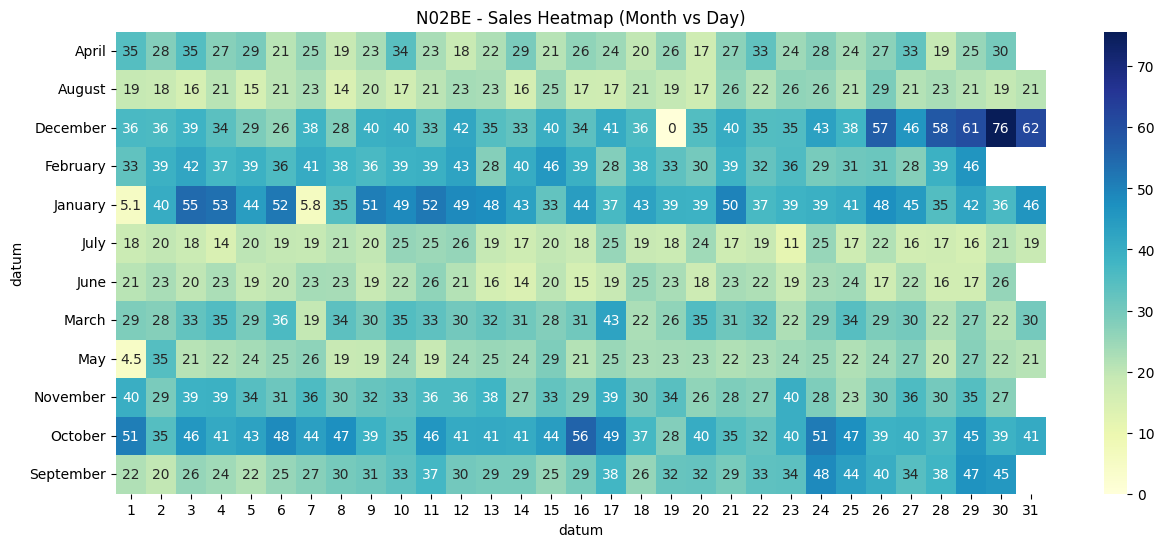

In [15]:
pivot_table = df_daily_long[df_daily_long['category'] == 'N02BE']\
    .pivot_table(index=df_daily_long['datum'].dt.month_name(),
                 columns=df_daily_long['datum'].dt.day,
                 values='units_sold')

plt.figure(figsize=(15,6))
sns.heatmap(pivot_table, cmap="YlGnBu" , annot=True)
plt.title("N02BE - Sales Heatmap (Month vs Day)")
plt.show()


16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing


N02BE Prophet MAE: 8.48
N02BE Prophet RMSE: 10.16


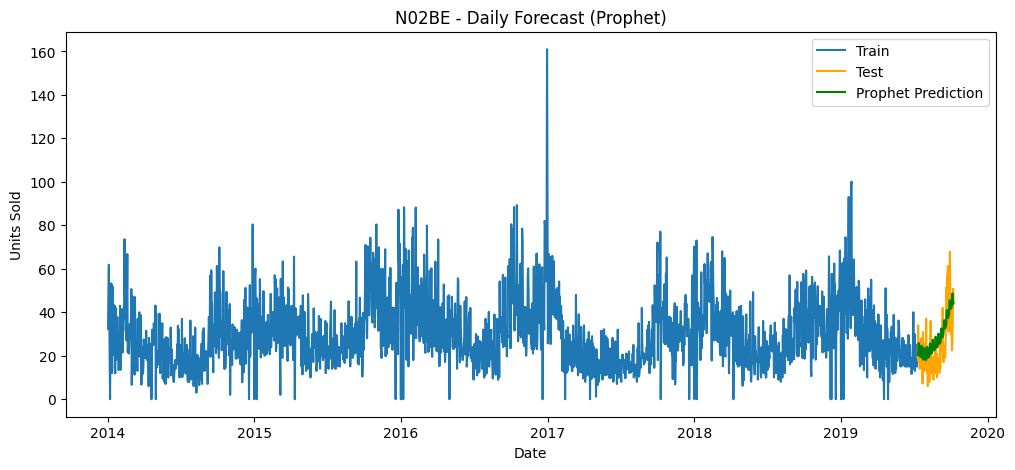

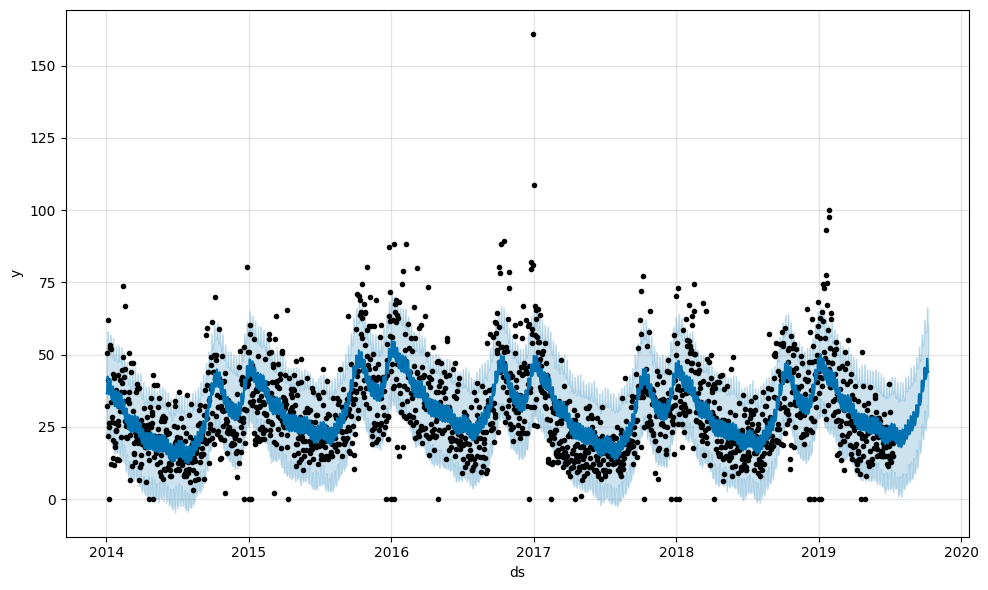

In [16]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Filter for N02BE
df_n02be = df_daily_long[df_daily_long['category'] == 'N02BE'].copy()

# Prepare for Prophet
df_prophet = df_n02be[['datum', 'units_sold']].rename(columns={'datum': 'ds', 'units_sold': 'y'})

# Train-test split (last 90 days for testing)
train = df_prophet.iloc[:-90]
test = df_prophet.iloc[-90:]

# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(train)

# Forecast for the test period
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Extract predictions only for the test period
pred = forecast.set_index('ds').loc[test['ds'], 'yhat']

# Evaluate
mae = mean_absolute_error(test['y'], pred)
rmse = np.sqrt(mean_squared_error(test['y'], pred))

print(f"N02BE Prophet MAE: {mae:.2f}")
print(f"N02BE Prophet RMSE: {rmse:.2f}")

# Plot forecast vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test', color='orange')
plt.plot(test['ds'], pred, label='Prophet Prediction', color='green')
plt.title("N02BE - Daily Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

# Prophet's built-in plot
model.plot(forecast)
plt.show()
